In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
results = {1: {'Random': {'top1': 0.11053362240393956, 'top5': 0.5540674070517222, 'mrr': 0.313596052924792}, 'GPT2': {'top1': 0.14863679284850756, 'top5': 0.6113387783368428, 'mrr': 0.3536674251159032}},
10: {'Random': {'top1': 0.11232161720593771, 'top5': 0.5553334454695383, 'mrr': 0.31528549989064536}, 'GPT2': {'top1': 0.19394191751877468, 'top5': 0.6798434138298035, 'mrr': 0.4013139992952347}},
100: {'Random': {'top1': 0.110750179986159, 'top5': 0.5560719708601634, 'mrr': 0.31409805119037626}, 'GPT2': {'top1': 0.24603809267282487, 'top5': 0.701660277446111, 'mrr': 0.4442773014307022}},}

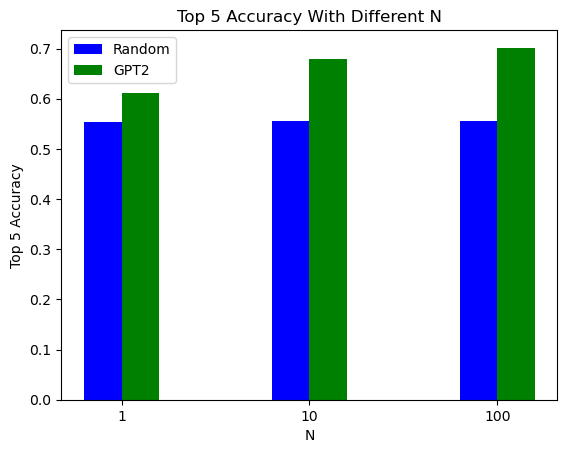

In [11]:
import matplotlib.pyplot as plt

x = np.arange(3)

y = np.array([results[10**i]["Random"]["top5"] for i in x])
z = np.array([results[10**i]["GPT2"]["top5"] for i in x])

ax = plt.subplot(111)
ax.bar(x-0.1, y, width=0.2, color='b', align='center', label="Random")
ax.bar(x+.1, z, width=0.2, color='g', align='center', label="GPT2")

plt.xticks(np.arange(3), [1, 10, 100])
plt.legend()
plt.xlabel("N")
plt.ylabel("Top 5 Accuracy")

plt.title("Top 5 Accuracy With Different N")
# plt.savefig("fewshot.png")
plt.show()

In [5]:
ways = 9

# Extract and open datasets

import zipfile
with zipfile.ZipFile(f"../{ways}_way_dataset.zip", 'r') as f:
    f.extractall()

with open(f"{ways}_way_dataset.pkl", "rb") as f:
    x_train, y_train, x_valid, y_valid, x_test, y_test, m_train, m_valid, m_test = pickle.load(f)

composers = np.unique(y_train)
y_train = np.stack(y_train)
y_test = np.stack(y_test)

In [6]:
def sample_data(N=10):
    composer_pieces = {composer:np.argwhere(y_train == composer).flatten() for composer in composers}
    indices = np.concatenate([np.random.choice(piece_indices, size=(N,), replace=False) for piece_indices in composer_pieces.values()])

    return indices

In [7]:
import pandas as pd

# Helper func
def expand_repeat(arr, repeats, axis=0):
    return np.repeat(np.expand_dims(arr, axis=axis), repeats, axis=axis)

def fit_and_predict(train, test, indices, k=3): # Function to take x_few and y_few and make guesses about all the x_test samples

    few_features = train[indices]# extractor(x_few, test=False) # L x d (where L is N*#composers)
    test_features = test# extractor(x_test, test=True)# M x d (This should retreive cached values)

    # Want to end with M x L vector

    euclideans = np.sqrt(np.sum(np.square(expand_repeat(few_features, len(x_test), 0) - expand_repeat(test_features, len(indices), 1)), axis=-1))

    avg_euclideans = np.zeros((len(x_test), ways))

    for i, composer in enumerate(composers):
        composer_points = np.argwhere(y_train[indices] == composer).flatten()

        avg_euclideans[:, i] = np.mean(np.sort(euclideans[:, composer_points], axis=-1)[..., :k], axis=-1)
        # avg_euclideans[:, i] = np.mean(euclideans[:, composer_points], axis=-1)

    ranks = np.argsort(avg_euclideans, axis=-1)

    return ranks

In [8]:
def top_x_acc(y_true, y_pred, x):
    y_true = torch.Tensor(y_true)
    y_pred = torch.Tensor(y_pred)
    # ranked = torch.argsort(y_pred, axis=-1)
    top_x = y_pred[..., :x]
    # print(ranked.shape)
    return (top_x == torch.repeat_interleave(y_true.unsqueeze(-1), x, axis=-1)).float().sum(-1).mean().item()

def mean_recip_rank(y_true, y_pred):
    y_true = torch.Tensor(y_true)
    y_pred = torch.Tensor(y_pred)
    # ranked = torch.argsort(y_pred, axis=-1)
    
    # print(ranked.shape, torch.repeat_interleave(y_true.unsqueeze(-1), y_true.shape[-1], axis=-1).shape)

    # starts with worst at 0 but we want best at 1 so
    true_ranks = (y_pred == torch.repeat_interleave(y_true.unsqueeze(-1), y_pred.shape[-1], axis=-1)).float().argmax(-1) + 1

    return (1/true_ranks).mean().item()

In [22]:
from tqdm.autonotebook import tqdm

T = 30


def random_extractor(x, test=False): # function to get extracted features from data
    d = 5
    return np.random.normal(size=(len(x), d))


models = {"Random":("random_train_vecs.npy", "random_test_vecs.npy"), "GPT2":("gpt2_train_vecs.npy", "gpt2_test_vecs.npy")} # gpt2_extract defined later.  Go run that first
Ns = [1, 10, 100]

results = {}

for N in Ns:
    results[N] = {}
    print()
    print(f"N: {N}")
    print()

    for model_name, files in models.items():
        train_file, test_file = files
        train, test = np.load(train_file), np.load(test_file)

        print(f"Model: {model_name}")

        top1s = []
        top5s = []
        mrrs = []

        for _ in tqdm(range(T)):
            indices = sample_data(N=N)

            y_pred = fit_and_predict(train, test, indices)
            y_true = np.array([list(composers).index(i) for i in y_test])

            top1 = top_x_acc(y_true, y_pred, 1)
            top5 = top_x_acc(y_true, y_pred, 5)
            mrr = mean_recip_rank(y_true, y_pred)

            top1s.append(top1)
            top5s.append(top5)
            mrrs.append(mrr)

        results[N][model_name] = {"top1":np.mean(top1s), "top5":np.mean(top5s), "mrr":np.mean(mrrs)}


N: 1

Model: Random


100%|██████████| 30/30 [00:07<00:00,  4.05it/s]


Model: GPT2


100%|██████████| 30/30 [00:07<00:00,  4.03it/s]



N: 10

Model: Random


100%|██████████| 30/30 [01:04<00:00,  2.16s/it]


Model: GPT2


100%|██████████| 30/30 [01:06<00:00,  2.22s/it]



N: 100

Model: Random


100%|██████████| 30/30 [11:56<00:00, 23.89s/it]


Model: GPT2


100%|██████████| 30/30 [11:40<00:00, 23.35s/it]


In [27]:
for N in Ns:
    print(N, results[N])

1 {'Random': {'top1': 0.11043922553459803, 'top5': 0.5555666605631511, 'mrr': 0.3140404452880224}, 'GPT2': {'top1': 0.14830362672607103, 'top5': 0.6211005628108979, 'mrr': 0.35541171630223595}}
10 {'Random': {'top1': 0.11065578361352285, 'top5': 0.5549614131450653, 'mrr': 0.3140551924705505}, 'GPT2': {'top1': 0.19906157950560252, 'top5': 0.6917874336242675, 'mrr': 0.408221701780955}}
100 {'Random': {'top1': 0.11018934994935989, 'top5': 0.5551557580629984, 'mrr': 0.31349858542283376}, 'GPT2': {'top1': 0.23849741816520692, 'top5': 0.7456327398618062, 'mrr': 0.4489776700735092}}


In [52]:
train_file, test_file = ("random_train_vecs.npy", "random_test_vecs.npy")
train, test = np.load(train_file), np.load(test_file)

print(train.shape, test.shape)
print(train.dtype, test.dtype)

(27999, 768) (6003, 768)
float64 float64


In [53]:
train_file, test_file = ("gpt2_train_vecs.npy", "gpt2_test_vecs.npy")
train, test = np.load(train_file), np.load(test_file)

print(train.shape, test.shape)
print(train.dtype, test.dtype)

(27999, 768) (6003, 768)
float32 float32


In [16]:
from pathlib import Path
import encoders
import json
import sys
import torch
import evaluate
import transformers
import numpy as np
import pandas as pd
import pickle

from pathlib import Path
from tqdm.auto import tqdm
from datasets import Dataset
from transformers import AutoConfig, \
    DataCollatorWithPadding, AutoModelForSequenceClassification, \
    Trainer, TrainingArguments, AutoTokenizer

In [17]:
# Classifier Finetuning
data_path = Path("/home/ajain/ttmp/PBSCSR_data/gpt2/")

enc_name = "dense_1_8"
    
tokenizer_path = data_path/"pretrained_model"/"tokenizer.json"  

load_pretrained_weights = True
'''Whether to load pretrained weights: bool'''
pretrained_output_model_path = data_path/"pretrained_model"
'''Location of the pretrained weights'''

def data_preparation():
    """Prepare data for training, validation, and testing.
    
    Returns
    -------
    train_df : pd.DataFrame
        Training data with 2 columns, "text" and "label".
    val_df : pd.DataFrame
        Validation data with 2 columns, "text" and "label".
    test_df : pd.DataFrame
        Testing data with 2 columns, "text" and "label".
    """

    with open("/home/abunn/ttmp/ExplorationWithLLMs/source/03_alec_temp_name/finetuning_data/dense_1_8.pkl", "rb") as f:
        x_train, y_train, x_valid, y_valid, x_test, y_test = pickle.load(f)

    train_df = pd.DataFrame({"text":x_train, "label":y_train})
    valid_df = pd.DataFrame({"text":x_valid, "label":y_valid})
    test_df = pd.DataFrame({"text":x_test, "label":y_test})
    
    return train_df, valid_df, test_df

    
def tokenizer_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True)

def label2id_function(examples):
    return {"label": [label2id[label] for label in examples["label"]]}

# Prepare data
train_df, val_df, test_df = data_preparation()
train_ds = Dataset.from_dict(train_df)
val_ds = Dataset.from_dict(val_df)
test_ds = Dataset.from_dict(test_df)

# Define label map
label2id = {label: i for i, label in enumerate(set(train_df['label']))}
id2label = {i: label for label, i in label2id.items()}

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path.parent)
config = AutoConfig.from_pretrained(pretrained_output_model_path)
config.num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_output_model_path, config=config)
    
tokenizer.pad_token = '<pad>'
model.pad_token_id = tokenizer.pad_token_id
tokenizer.model_max_length = config.n_positions
config.pad_token_id = tokenizer.pad_token_id

# Tokenize and convert labels to ids
train_ds = train_ds.map(tokenizer_function, batched=True)
val_ds = val_ds.map(tokenizer_function, batched=True)
train_ds = train_ds.map(label2id_function, batched=True)
val_ds = val_ds.map(label2id_function, batched=True)
test_ds = test_ds.map(tokenizer_function, batched=True)
test_ds = test_ds.map(label2id_function, batched=True)

ds_list = [train_ds, val_ds, test_ds]
ds_list = [ds.remove_columns(["text"]) for ds in ds_list]
ds_list = [ds.rename_column("label", "labels") for ds in ds_list]
[ds.set_format("torch") for ds in ds_list]

# Designate GPUs if possible and parallelize (disabled for now)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /home/ajain/ttmp/PBSCSR_data/gpt2/pretrained_model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 6003/6003 [00:00<00:00, 82300.13 examples/s]


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(30001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=9, bias=False)
)

In [18]:
import torch.nn as nn
new_model = nn.Sequential(*list(model.children())[:-1])

print(new_model)

Sequential(
  (0): GPT2Model(
    (wte): Embedding(30001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
)


In [19]:
def gpt2_extract(x):
    encoded = [encoders.dense_encoder(i, block_size=[1, 8]) for i in x]

    tokenized = torch.Tensor([i[:64] for i in tokenizer(encoded)['input_ids']]).to(device).long()
    
    # Do in batches to ensure no OOM
    batch_size = 32

    extracted = []
    with torch.no_grad():
        for i in tqdm(range(0, tokenized.shape[0], batch_size)):
            extracted.append(new_model(tokenized[i:i+batch_size])["last_hidden_state"][:, -1])

    extracted = torch.cat(extracted, axis=0)

    return extracted.cpu().numpy()

In [20]:
gpt2_test_vecs = gpt2_extract(x_test)
gpt2_train_vecs = gpt2_extract(x_train)

np.save("gpt2_test_vecs.npy", gpt2_test_vecs)
np.save("gpt2_train_vecs.npy", gpt2_train_vecs)

100%|██████████| 875/875 [00:13<00:00, 66.49it/s]


In [21]:
np.save("random_test_vecs.npy", np.random.normal(size=gpt2_test_vecs.shape).astype(np.float32))
np.save("random_train_vecs.npy", np.random.normal(size=gpt2_train_vecs.shape).astype(np.float32))

In [34]:
# np.save("gpt2_test_vecs.npy", gpt2_test_vecs)

In [ ]:
with open("gpt2_test_vecs.pkl", "wb") as f:
    pickle.dump(gpt2_test_vecs, f)

In [27]:
print(x_train[:9].shape)
print(gpt2_extract(x_train[:9]).shape)

(9, 64, 62)
(9, 768)


In [171]:
print(x_train[:2].shape)

(2, 64, 62)
